# Lab 3 : EEP 595

## Introduction to Privacy Engineering, Spring 2022


## Differential Privacy

##### Installation:

Same as Lab 1. <br>No additional packages are required.

##### This lab contains 10 questions.
The first 8 questions are coding questions. <br>
The last 2 questions can be answered in words. 

##### Grading rubric: for each question,
100% of the points - Correct code, correct output<br>
50% of the points - Minor logical error, partial output<br>
0% of the points - No attempt, incomplete code, wrong output

##### Submission instructions

You will have to submit the completed jupyter notebook file (.ipynb) in Canvas. <br> 
Please rename the submission file in the 'FirstName-LastName-Lab3.ipynb'format.

##### Acknowledgement

Adapted from UVM CS 29 <br>
Link: https://jnear.github.io/cs295-data-privacy/ 

# Differential Privacy

Like $k$-Anonymity, *differential privacy* is a formal notion of privacy. Unlike $k$-Anonymity, however, differential privacy is a property of *algorithms*, and not a property of *data*. That is, we can prove that an *algorithm* satisfies differential privacy; to show that a *dataset* satisfies differential privacy, we must show that the algorithm which produced it satisfies differential privacy.

A function which satisfies differential privacy is often called a *mechanism*. We say that a *mechanism* $F$ satisfies differential privacy if for all *neighboring datasets* $x$ and $x'$, and all possible outputs $S$,

\begin{align}
\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = S]} \leq e^\epsilon
\end{align}

Two datasets are considered neighbors if they differ in the data of a single individual. Note that $F$ is typically a *randomized* function, so that the probability distribution describing its outputs is not just a point distribution.

The important implication of this definition is that $F$'s output will be pretty much the same, *with or without* the data of any specific individual. In other words, the randomness built into $F$ should be "enough" so that an observed output from $F$ will not reveal which of $x$ or $x'$ was the input. Imagine that my data is present in $x$ but not in $x'$. If an adversary can't determine which of $x$ or $x'$ was the input to $F$, then the adversary can't tell whether or not my data was *present* in the input - let alone the contents of that data.

The $\epsilon$ parameter in the definition is called the *privacy parameter* or the *privacy budget*. $\epsilon$ provides a knob to tune the "amount of privacy" the definition provides. Small values of $\epsilon$ require $F$ to provide *very* similar outputs when given similar inputs, and therefore provide higher levels of privacy; large values of $\epsilon$ allow less similarity in the outputs, and therefore provide less privacy. 

How should we set $\epsilon$ to prevent bad outcomes in practice? Nobody knows. The general consensus is that $\epsilon$ should be around 1 or smaller, and values of $\epsilon$ above 10 probably don't do much to protect privacy - but this rule of thumb could turn out to be very conservative. 

## The Laplace Mechanism

Differential privacy is typically used to answer specific queries. Let's consider a query on the census data, *without* differential privacy.

Census data is available in the csv file. titled 'adult_with_pii.csv' 
This csv file is available in your Lab 3 folder. 

Dataset source: http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
adult = pd.read_csv("adult_with_pii.csv")

In [2]:
adult.columns

Index(['Name', 'DOB', 'SSN', 'Zip', 'Age', 'Workclass', 'fnlwgt', 'Education',
       'Education-Num', 'Martial Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country',
       'Target'],
      dtype='object')

"How many individuals in the dataset are 40 years old or older?"

In [3]:
adult[adult['Age'] >= 40].shape[0]

14237

The easiest way to achieve differential privacy for this query is to add random noise to its answer. The key challenge is to add enough noise to satisfy the definition of differential privacy, but not so much that the answer becomes too noisy to be useful. To make this process easier, some basic *mechanisms* have been developed in the field of differential privacy, which describe exactly what kind of - and how much - noise to use. One of these is called the *Laplace mechanism*.

According to the Laplace mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $\epsilon$-differential privacy:

\begin{align}
F(x) = f(x) + \textsf{Lap}(\frac{s}{\epsilon})
\end{align}

where $s$ is the *sensitivity* of $f$, and $\textsf{Lap}(S)$ denotes sampling from the Laplace distribution with center 0 and scale $S$.

The *sensitivity* of a function $f$ is the amount $f$'s output changes when its input changes by 1. Sensitivity is a complex topic, and an integral part of designing differentially private algorithms;  For now, we will just point out that *counting queries* always have a sensitivity of 1: if a query counts the number of rows in the dataset with a particular property, and then we modify exactly one row of the dataset, then the query's output can change by at most 1.

Thus we can achieve differential privacy for our example query by using the Laplace mechanism with sensitivity 1 and an $\epsilon$ of our choosing. For now, let's pick $\epsilon = 0.1$. We can sample from the Laplace distribution using Numpy's `random.laplace`.

In [4]:
sensitivity = 1
epsilon = 0.1

adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

14201.57859799657

You can see the effect of the noise by running the proceeding cell multiple times. Each time, the output changes, but most of the time, the answer is close enough to the true answer (14,235) to be useful.

##### Question 1:  ( 2 points )

How many individuals in the dataset work for 60 hours or more per week? 

In [5]:
## Question 1
## YOUR CODE HERE
adult[adult['Hours per week'] >= 60].shape[0]


2585

##### Question 2:  ( 5 points )

To achieve differential privacy for the query in Q.1, use the Laplace mechanism with sensitivitiy 1.

For $\epsilon$ in [ 0.1, 0.2, 0.3, ...., 4.8, 4.9, 5.0 ], which $\epsilon$ value resulted in an output that was farthest from the answer in Question 1 ? 

Note: the output changes everytime the cell is executed. 

In [6]:
## Question 2
## YOUR CODE HERE
import random
sensitivity = 1
epsilon = random.randrange(1,51)/10

adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

14237.182083818856

For specific applications, the $\epsilon$ value can be chosen depending on the privacy budget requirements. 

## How Much Noise is Enough?

How do we know that the Laplace mechanism adds enough noise to prevent the re-identification of individuals in the dataset? For one thing, we can try to break it! Let's write down a malicious counting query, which is specifically designed to determine whether Karrie Trusslove has an income greater than \$50k.

In [7]:
karries_row = adult[adult['Name'] == 'Karrie Trusslove']
karries_row[karries_row['Target'] == '<=50K'].shape[0]

1

This result definitely violates Karrie's privacy, since it reveals the value of the income column for Karrie's row. Since we know how to ensure differential privacy for counting queries with the Laplace mechanism, we can do so for this query:

In [8]:
sensitivity = 1
epsilon = 0.1

karries_row = adult[adult['Name'] == 'Karrie Trusslove']
karries_row[karries_row['Target'] == '<=50K'].shape[0] + \
  np.random.laplace(loc=0, scale=sensitivity/epsilon)

5.195582645113084

Is the true answer 0 or 1? There's too much noise to be able to reliably tell. This is how differential privacy is *intended* to work - the approach does not *reject* queries which are determined to be malicious; instead, it adds enough noise that the results of a malicious query will be useless to the adversary.

# Properties of Differential Privacy

This section describes three important properties of differentially private mechanisms that arise from the definition of differential privacy. These properties will help us to design useful algorithms that satisfy differential privacy, and ensure that those algorithms provide accurate answers. The three properties are:

- Sequential composition
- Parallel composition
- Post processing

Different epsilon values are defined as follows: 

$\epsilon_1$ = 1 \
$\epsilon_2$ = 1 \
$\epsilon_{total}$ = 2

In [9]:
epsilon1 = 1
epsilon2 = 1
epsilon_total = 2

## Sequential Composition

The first major property of differential privacy is *sequential composition*, which bounds the total privacy cost of releasing multiple results of differentially private mechanisms on the same input data. Formally, the sequential composition theorem for differential privacy says that:

Sequential composition: If you perform two (or more) differentially private computations, they collectively provide differential privacy with parameter bounded by the sum of the parameters you used

- If $F_1(x)$ satisfies $\epsilon_1$-differential privacy
- And $F_2(x)$ satisfies $\epsilon_2$-differential privacy
- Then the mechanism $G(x) = (F_1(x), F_2(x))$ which releases both results satisfies $\epsilon_1+\epsilon_2$-differential privacy

Sequential composition is a vital property of differential privacy because it enables the design of algorithms that consult the data more than once. Sequential composition is also important when multiple separate analyses are performed on a single dataset, since it allows individuals to bound the *total* privacy cost they incur by participating in all of these analyses.
The bound on privacy cost given by sequential composition is an *upper* bound - the actual privacy cost of two particular differentially private releases may be smaller than this, but never larger. We aren't discussing the proof of this bound in this lab assignment.

The principle that the $\epsilon$s "add up" makes sense if we examine the distribution of outputs from a mechanism which averages two differentially private results together. Let's look at some examples.

##### Question 3:  ( 2 points )

Define a function `F1` that has no input parameters and returns a value sampled from the Laplace Mechanism such that the sensitivity is 1 and privacy budget is $\epsilon_{1}$

Note that this function satisfies $\epsilon_{1}$-differential privacy ( $\epsilon_{1}$ = 1 ). 

In [10]:
sensitivity = 1

In [11]:
## Question 3
## YOUR CODE HERE
F1 = lambda : np.random.laplace(loc=0, scale=sensitivity/epsilon1)
F1()

1.7873260379887448

##### Question 4:  ( 2 points )

Define a function `F2` that has no input parameters and returns a value sampled from the Laplace Mechanism such that the sensitivity is 1 and privacy budget is $\epsilon_{2}$

Note that this function satisfies $\epsilon_{2}$-differential privacy ( $\epsilon_{2}$ = 1 ). 

In [12]:
## Question 4
## YOUR CODE HERE
F2 = lambda : np.random.laplace(loc=0, scale=sensitivity/epsilon2)
F2()

-0.34557700719112466

##### Question 5: ( 2 points )

Define a function `F_total` that has no input parameters and returns a value sampled from the Laplace Mechanism such that the sensitivity is 1 and privacy budget is $\epsilon_{total}$

Note that this function satisfies $\epsilon_{total}$-differential privacy. In this case, $\epsilon_{total}$ = 2. 

In [13]:
## Question 5
## YOUR CODE HERE
F_total = lambda : np.random.laplace(loc=0, scale=sensitivity/epsilon_total)
F_total()

0.5662941539382161

##### Question 6: ( 2 points )

As mentioned before, the principle that the $\epsilon$s "add up" makes sense if we examine the distribution of outputs from a mechanism which averages two differentially private results together. Let's define this mechanism. 

Define a function `F_mean` that has no input parameters and returns the mean of the outputs of the functions `F1` and `F2` 

`F_mean` is an example of sequential composition.
From the definition of sequential composition, this function also satisfies $\epsilon_{total}$-differential privacy. In this case, $\epsilon_{total}$ = 2. 


In [14]:
## Question 6
## YOUR CODE HERE
F_mean = lambda :(F1()+F2())/2
F_mean()

0.41417111329655554

Now that our example mechanisms/functions have been defined,
Let's look at the distribution of their outputs. 

If we graph `F1` and `F2`, we see that the distributions of their outputs look pretty similar.

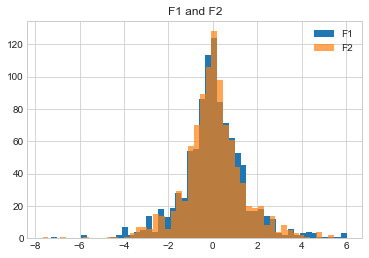

In [15]:
plt.title("F1 and F2")
plt.hist([F1() for i in range(1000)], bins=50, label='F1');
plt.hist([F2() for i in range(1000)], bins=50, alpha=.7, label='F2');
plt.legend();


If we graph `F1` and `F_total`, we see that the distribution of outputs from `F_total` looks "pointier" than that of `F1`, because `F_total`'s higher $\epsilon$ implies less privacy, and therefore a smaller liklihood of getting results far from the true answer.

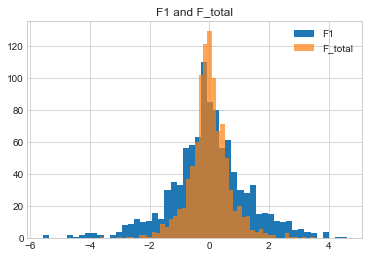

In [16]:
plt.title("F1 and F_total")
plt.hist([F1() for i in range(1000)], bins=50, label='F1');
plt.hist([F_total() for i in range(1000)], bins=50, alpha=.7, label='F_total');
plt.legend();

If we graph `F1` and `F_mean`, we see that the distribution of outputs from `F_mean` is pointier. This means `F_mean`'s answers are more accurate than those of `F1`, so it makes sense that its $\epsilon$ must be higher (i.e. it yields less privacy than `F1`).

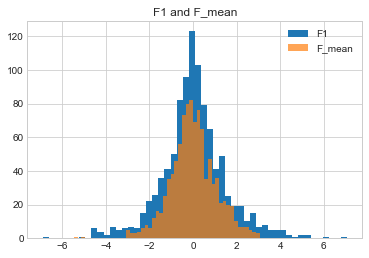

In [24]:
plt.title("F1 and F_mean")
plt.hist([F1() for i in range(1000)], bins=50, label='F1');
plt.hist([F_mean() for i in range(1000)], bins=50, alpha=.7, label='F_mean');
plt.legend();

What about `F_total` and `F_mean`? Recall that the $\epsilon$ values for these two mechanisms are the same - both have an $\epsilon$ of 2.

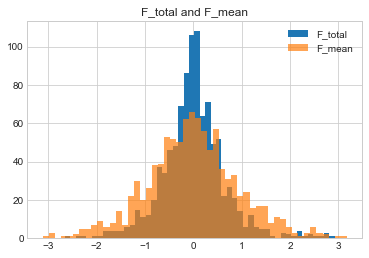

In [18]:
plt.title("F_total and F_mean")
plt.hist([F_total() for i in range(1000)], bins=50, label='F_total');
plt.hist([F_mean() for i in range(1000)], bins=50, alpha=.7, label='F_mean');
plt.legend();

Observe that `F_total` looks "pointier"! Why does this happen? Remember that sequential composition yields an *upper* bound on the total $\epsilon$ of several releases, but this upper bound might not be tight. That's the case here - the actual privacy loss in this case appears to be somewhat lower than the upper bound $\epsilon$ determined by sequential composition. Sequential composition is an extremely useful way to control total privacy cost, but keep in mind that the bound it provides is often quite loose.

## Parallel Composition

The second important property of differential privacy is called *parallel composition*. Parallel composition can be seen as an alternative to sequential composition - a second way to calculate a bound on the total privacy cost of multiple data releases. Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Since the chunks are disjoint, each individual's data appears in *exactly* one chunk - so even if there are $k$ chunks in total (and therefore $k$ runs of the mechanism), the mechanism runs exactly once on the data of each *individual*. Formally,

 - If $F(x)$ satisfies $\epsilon$-differential privacy
 - And we split a dataset $X$ into $k$ disjoint chunks such that $x_1 \cup ... \cup x_k = X$
 - Then the mechanism which releases all of the results $F(x_1), ..., F(x_k)$ satisfies $\epsilon$-differential privacy
 
Note that this is a much better bound than sequential composition would give. Since we run $F$ $k$ times, sequential composition would say that this procedure satisfies $k\epsilon$-differential privacy. Parallel composition allows us to say that the total privacy cost is just $\epsilon$.

The formal definition matches up with our intuition - if each participant in the dataset contributes one row to $X$, then this row will appear in *exactly* one of the chunks $x_1, ..., x_k$. That means $F$ will only "see" this participant's data *one time*, meaning a privacy cost of $\epsilon$ is appropriate for that individual. Since this property holds for all individuals, the privacy cost is $\epsilon$ for everyone.

### Histograms

In our context, a *histogram* is an analysis of a dataset which splits the dataset into "bins" based on the value of one of the data attributes, and counts the number of rows in each bin. For example, a histogram might count the number of people in the dataset who achieved a particular educational level.

In [19]:
adult = pd.read_csv("adult_with_pii.csv")
adult.dropna()
adult['Education'].value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: Education, dtype: int64

Histograms are particularly interesting for differential privacy because they automatically satisfy parallel composition. Each "bin" in a histogram is defined by a possible value for a data attribute (for example, `'Education' == 'HS-grad'`). It's impossible for a single row to have *two* values for an attribute simultaneously, so defining the bins this way *guarantees* that they will be disjoint. Thus we have satisfied the requirements for parallel composition, and we can use a differentially private mechanism to release *all* of the bin counts with a total privacy cost of just $\epsilon$.

In [20]:
epsilon = 1
adult['Education'].value_counts().apply(lambda x: x + np.random.laplace(loc=0, scale=1/epsilon))

HS-grad         10503.342675
Some-college     7293.119851
Bachelors        5355.374436
Masters          1724.699323
Assoc-voc        1381.302490
11th             1174.319457
Assoc-acdm       1065.777126
10th              934.041286
7th-8th           641.715844
Prof-school       575.866969
9th               513.070712
12th              433.531477
Doctorate         412.720591
5th-6th           333.013931
1st-4th           168.754101
Preschool          49.195655
Name: Education, dtype: float64

This analysis has a total privacy cost of epsilon = 1 ( from the definition of parallel composition ) , even though we release 16 results!

##### Question 7: ( 3 points )

Create a histogram (based on the definition above) that counts the number of people in the 'adult' dataset based on their occupation. 

In [21]:
adult['Occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: Occupation, dtype: int64

In [22]:
## Question 7
## YOUR CODE HERE: 
adult['Occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: Occupation, dtype: int64



##### Question 8: ( 2 points )

Apply the Laplace Mechanism via parallel composition to all the 'Occupation' bins. Use sensitivity = 1 and $\epsilon = 0.1$ 

In [23]:
## Question 8
## YOUR CODE HERE: 
epsilon = 0.1
adult['Occupation'].value_counts().apply(lambda x: x + np.random.laplace(loc=0, scale=1/epsilon))

Prof-specialty       4135.828920
Craft-repair         4113.031775
Exec-managerial      4075.353034
Adm-clerical         3780.276711
Sales                3670.778673
Other-service        3285.954973
Machine-op-inspct    1981.830268
Transport-moving     1599.172111
Handlers-cleaners    1372.396880
Farming-fishing      1001.045946
Tech-support          963.467017
Protective-serv       655.403819
Priv-house-serv       154.677882
Armed-Forces           12.156302
Name: Occupation, dtype: float64

##### Question 9: (1 point)

Using the property of parallel decomposition, what is the total privacy cost $\epsilon$ of the release in Q.8 ?

Enter your answer in the cell below.

##### Answer:  Total privacy cost is $\epsilon$ = 0.1

## Post-processing

The third property of differential privacy we will discuss here is called *post-processing*. The idea is simple: it's impossible to reverse the privacy protection provided by differential privacy by post-processing the data in some way. Formally:

- If $F(X)$ satisfies $\epsilon$-differential privacy
- Then for any (deterministic or randomized) function $g$, $g(F(X))$ satisfies $\epsilon$-differential privacy

The post-processing property means that it's always safe to perform arbitrary computations on the output of a differentially private mechanism - there's no danger of reversing the privacy protection the mechanism has provided. In particular, it's fine to perform post-processing that might reduce the noise or improve the signal in the mechanism's output (e.g. replacing negative results with zeros, for queries that shouldn't return negative results). In fact, many sophisticated differentially private algorithms make use of post-processing to reduce noise and improve the accuracy of their results.

The other implication of the post-processing property is that differential privacy provides resistance against privacy attacks based on auxiliary information. For example, the function $g$ might contain auxiliary information about elements of the dataset, and attempt to perform a linking attack using this information. The post-processing property says that such an attack is limited in its effectiveness by the privacy parameter $\epsilon$, regardless of the auxiliary information contained in $g$.

#### Question 10: (4 points)

For the following mechanisms, which property of differential privacy ( among sequential decomposition, parallel decomposition, post-processing ) can be used to determine the privacy budget $\epsilon$ ?

Mechanism 1: Addition of 100,000 differentially private results. \
Mechanism 2: Applying the Sigmoid function on a differentially private result. 

The $\epsilon$ values associated with the differentially private results are known. 

###### Answers:
- Mechanism 1: Property -parallel decomposition
- Mechanism 2: Property - Post-processing